## Attendance Data Cleaning

Using python to clean and analyze quarterly employee attendance data exported from ADP for the Months of October 2023 to December 2023.

In [51]:
#Importing Packages
import pandas as pd
import datetime as dt
import string as str
import matplotlib.pyplot as plt

In [52]:
df = pd.read_csv(r"/Users/scipio/Downloads/Attendance_Data_Oct_Dec.csv", parse_dates = ['In_time','Out_time'])
campus = pd.read_csv(r"/Users/scipio/Downloads/Quarterly Finacial Report - Campus.csv")

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11298 entries, 0 to 11297
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Last_Name          11298 non-null  object        
 1   First_Name         11298 non-null  object        
 2   Position_ID        11298 non-null  object        
 3   Worked_Department  11298 non-null  int64         
 4   State              11298 non-null  object        
 5   In_time            11298 non-null  datetime64[ns]
 6   Out_time           9616 non-null   datetime64[ns]
 7   Hours              11298 non-null  float64       
 8   Pay_Code           3776 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 794.5+ KB


In [54]:
df.shape

(11298, 9)

In [55]:
#Date Range
df['In_time'].agg(['min','max'])

min   2023-10-01
max   2023-12-29
Name: In_time, dtype: datetime64[ns]

In [56]:
#Filtering df based on REGSAL, REGSAL indicative of pay day
df = df[df['Pay_Code']!= 'REGSAL']

In [57]:
#Unexcused Absences
def Unexcused(x):
    if x == 'ABSENT':
        return 1
    elif x == 'SICK':
        return 1
    elif x == 'UNPAID TIME OFF':
        return 1
    elif x == 'PERSONAL':
        return 1
    elif x == 'LONGEVITY DAYS':
        return 1
    else:
        return 0
    
df['Unexcused'] = df['Pay_Code'].apply(lambda x: Unexcused(x))

In [58]:
#Excused Absences
def Excused(x):
    if x == 'COVID SICK':
        return 1
    elif x == 'HOLIDAY':
        return 1
    elif x == 'JURY':
        return 1
    elif x == 'PROFESSIONAL DEVELOPMENT':
        return 1
    elif x == 'RELIGIOUS OBSERVATION':
        return 1
    elif x == 'VACATION':
        return 1
    else:
        return 0
    
df['Excused'] = df['Pay_Code'].apply(lambda x: Excused(x))

In [59]:
#Aggregating Unexcused and Excused metrics
Att_calc = df.groupby(['Position_ID','First_Name', 'Last_Name', 'In_time','Out_time', 'Hours','Pay_Code'])[['Unexcused', 'Excused']].sum().reset_index()
Att_calc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091 entries, 0 to 2090
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Position_ID  2091 non-null   object        
 1   First_Name   2091 non-null   object        
 2   Last_Name    2091 non-null   object        
 3   In_time      2091 non-null   datetime64[ns]
 4   Out_time     2091 non-null   datetime64[ns]
 5   Hours        2091 non-null   float64       
 6   Pay_Code     2091 non-null   object        
 7   Unexcused    2091 non-null   int64         
 8   Excused      2091 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 147.1+ KB


In [60]:
#Adding Month Column
Att_calc['Month'] = Att_calc['In_time'].dt.strftime('%Y-%m')

In [61]:
#Adding School Days Column
def School_Days(x):
    if x == '2023-10':
        return 21
    elif x == '2023-11':
        return 16
    elif x == '2023-12':
        return 16

Att_calc['School_Days'] = Att_calc['Month'].apply(lambda x: School_Days(x))

In [62]:
#Day Type
def Day_Type(x):
    if x >= 5:
        return 1
    elif x <= 4:
        return 0.50
    elif x == 0:
        return 0
    
    
Att_calc['Day_Type'] = Att_calc['Hours'].apply(lambda x: Day_Type(x))

In [63]:
#Calculating Excused and Unexcused Absences based on Day Type
Att_calc['Excused_Abs_Calc'] = Att_calc['Excused'].mul(Att_calc['Day_Type'])
Att_calc['Unexcused_Abs_Calc'] = Att_calc['Unexcused'].mul(Att_calc['Day_Type'])

In [64]:
Att_calc.head()

,Position_ID,First_Name,Last_Name,In_time,Out_time,Hours,Pay_Code,Unexcused,Excused,Month,School_Days,Day_Type,Excused_Abs_Calc,Unexcused_Abs_Calc
0,33T000055,Johanna,Soto,2023-10-09,2023-10-09,8.0,HOLIDAY,0,1,2023-10,21,1.0,1.0,0.0
1,33T000055,Johanna,Soto,2023-11-01,2023-11-01,4.0,SICK,1,0,2023-11,16,0.5,0.0,0.5
2,33T000055,Johanna,Soto,2023-11-20,2023-11-20,8.0,HOLIDAY,0,1,2023-11,16,1.0,1.0,0.0
3,33T000055,Johanna,Soto,2023-11-21,2023-11-21,8.0,HOLIDAY,0,1,2023-11,16,1.0,1.0,0.0
4,33T000055,Johanna,Soto,2023-11-22,2023-11-22,8.0,HOLIDAY,0,1,2023-11,16,1.0,1.0,0.0


In [65]:
#Aggrgating Monthly Attendance Data
Monthly_Att_Calc = Att_calc.groupby(['Position_ID', 'First_Name', 'Last_Name','Month','School_Days'])[['Excused_Abs_Calc','Unexcused_Abs_Calc']].sum().reset_index()

In [66]:
#Creating 'Days Present','Possible Days', and Attendance Percentage columns
Monthly_Att_Calc['Days_Present'] = Monthly_Att_Calc['School_Days'] - (Monthly_Att_Calc['Excused_Abs_Calc'] +  Monthly_Att_Calc['Unexcused_Abs_Calc'])
Monthly_Att_Calc['Possible_Days'] = Monthly_Att_Calc['School_Days'] - Monthly_Att_Calc['Excused_Abs_Calc']
Monthly_Att_Calc['Att_Percentage'] = round((Monthly_Att_Calc['Days_Present'].div(Monthly_Att_Calc['Possible_Days'])),2)

In [71]:
#Editing Department Names to Campus Names
Monthly_Att_Calc.head()

,Position_ID,First_Name,Last_Name,Month,School_Days,Excused_Abs_Calc,Unexcused_Abs_Calc,Days_Present,Possible_Days,Att_Percentage,Campus
0,33T000055,Johanna,Soto,2023-10,21,1.0,0.0,20.0,20.0,1.00,HO
1,33T000055,Johanna,Soto,2023-11,16,5.0,0.5,10.5,11.0,0.95,HO
2,33T000055,Johanna,Soto,2023-12,16,5.0,1.0,10.0,11.0,0.91,HO
3,33T000063,Sheria,McRae,2023-10,21,1.0,0.0,20.0,20.0,1.00,HO
4,33T000063,Sheria,McRae,2023-11,16,8.0,0.0,8.0,8.0,1.00,HO


In [80]:
#Monthly Attendance Metrics
Monthly_Att_Avg = Monthly_Att_Calc.groupby('Month')['Att_Percentage'].mean().reset_index().sort_values(by= 'Month')

Monthly_Att_Avg['diff'] = Monthly_Att_Calc['Att_Percentage'].diff()
Monthly_Att_Avg['diff'] = Monthly_Att_Avg['diff'].fillna(0)
Monthly_Att_Avg['pct_change'] = round(Monthly_Att_Calc['Att_Percentage'].pct_change(),2)
Monthly_Att_Avg['pct_change'] = Monthly_Att_Avg['pct_change'].fillna(0)

Monthly_Att_Avg.head()

,Month,Att_Percentage,diff,pct_change
0,2023-10,0.945338,0.00,0.00
1,2023-11,0.894088,-0.05,-0.05
2,2023-12,0.887801,-0.04,-0.04


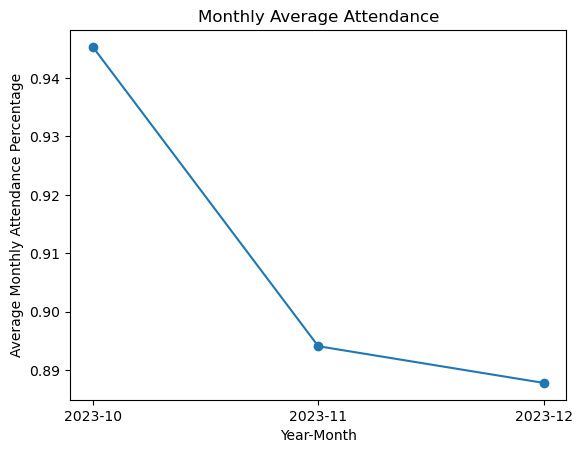

In [88]:
#Visualizing Monthly Attendance Metrics
plt.plot(Monthly_Att_Avg['Month'], Monthly_Att_Avg['Att_Percentage'], marker = 'o')

plt.xlabel('Year-Month')
plt.ylabel('Average Monthly Attendance Percentage')
plt.title('Monthly Average Attendance')
plt.show()

In [89]:
Monthly_Att_Calc.to_csv('Q2_Monthly_Att_Calc.csv', index = False, header = True)